In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import pickle
import scipy.io
import seaborn as sns
import tensorflow as tf
from keras.models import load_model, Model
from tqdm import tqdm
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.svm import SVC, LinearSVC
import os, sys
import imageio

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [ ]:
mat = scipy.io.loadmat("/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/AgeDB_metadata.mat")
fileno = list(map(lambda x: x[0], mat['fileno'][0]))
filename = list(map(lambda x: x[0], mat['filename'][0]))
name = list(map(lambda x: x[0], mat['name'][0]))
age = list(map(lambda x: x[0], mat['age'][0]))
gender = list(map(lambda x: x[0], mat['gender'][0]))
metadata_agedb = pd.DataFrame(np.stack([fileno, filename, name, age, gender]).T, 
                              columns=['fileno', 'filename', 'name', 'age', 'gender'])
metadata_agedb['age'] = metadata_agedb['age'].astype(np.int)
metadata_agedb['fileno'] = metadata_agedb['fileno'].astype(np.int)
metadata_agedb['name'] = metadata_agedb['name'].astype(np.str)
metadata_agedb['filename'] = metadata_agedb['filename'].astype(np.str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

In [ ]:
mat = scipy.io.loadmat("/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/celebrity2000_meta.mat")
age, identity, year, feature_1, feature_2, feature_3, feature_4, name = mat['celebrityImageData'][0][0]
metadata_CACD = pd.DataFrame(np.vstack([age.flatten(), identity.flatten(), year.flatten(), 
                            np.array(list(map(lambda x: x.tolist()[0][0].split("_")[1] + "_" + x.tolist()[0][0].split("_")[2], name))), 
                            np.array(list(map(lambda x: x.tolist()[0][0], name)))]).T, 
                  columns=['age', 'identity', 'year', 'name', 'filename'])
metadata_CACD['age'] = metadata_CACD['age'].astype(int)
metadata_CACD['identity'] = metadata_CACD['identity'].astype(int)
metadata_CACD['year'] = metadata_CACD['year'].astype(int)

In [ ]:
mat = scipy.io.loadmat("/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/FGNET_metadata.mat")
fileno, filename, age = mat['fileno'], mat['filename'], mat['age']
metadata_fgnet = pd.DataFrame(
    np.array([
        list(map(lambda x: x[0], fileno[0])), 
        list(map(lambda x: x[0], filename[0])), 
        list(map(lambda x: x[0], age[0]))
    ]).T, 
    columns=['fileno', 'filename', 'age']
)
metadata_fgnet['age'] = metadata_fgnet['age'].astype(np.int)
metadata_fgnet['fileno'] = metadata_fgnet['fileno'].astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

In [ ]:
metadata_agedb.head()

,fileno,filename,name,age,gender
0,0,0_MariaCallas_35_f.jpg,MariaCallas,35,f
1,10000,10000_GlennClose_62_f.jpg,GlennClose,62,f
2,10001,10001_GoldieHawn_23_f.jpg,GoldieHawn,23,f
3,10002,10002_GoldieHawn_24_f.jpg,GoldieHawn,24,f
4,10003,10003_GoldieHawn_24_f.jpg,GoldieHawn,24,f


In [ ]:
metadata_CACD.head()

,age,identity,year,name,filename
0,53,1,2004,Robin_Williams,53_Robin_Williams_0001.jpg
1,53,1,2004,Robin_Williams,53_Robin_Williams_0002.jpg
2,53,1,2004,Robin_Williams,53_Robin_Williams_0003.jpg
3,53,1,2004,Robin_Williams,53_Robin_Williams_0004.jpg
4,53,1,2004,Robin_Williams,53_Robin_Williams_0005.jpg


In [ ]:
metadata_fgnet.head()

,fileno,filename,age
0,1,001A02.JPG,2
1,1,001A05.JPG,5
2,1,001A08.JPG,8
3,1,001A10.JPG,10
4,1,001A14.JPG,14


### Age Distributions

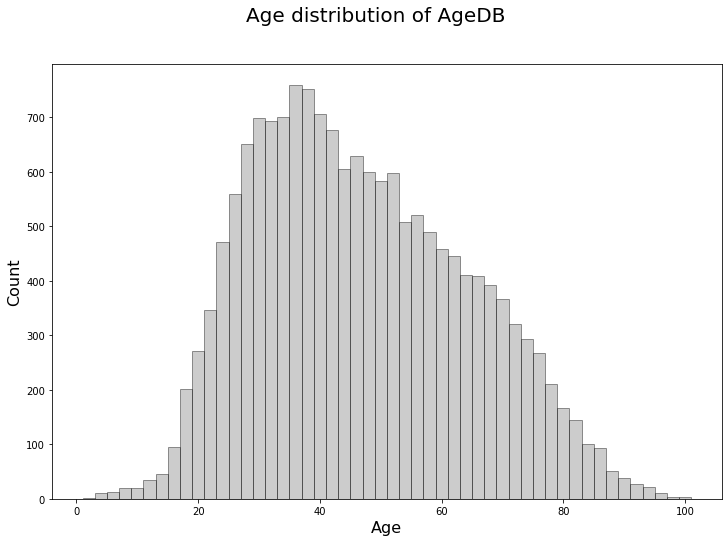

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.hist(metadata_agedb['age'], bins=50, color='gray', alpha=0.4, histtype='bar', ec='black')
plt.xlabel("Age", fontsize=16)
plt.ylabel("Count", fontsize=16)
fig.suptitle("Age distribution of AgeDB", fontsize=20)
plt.show()

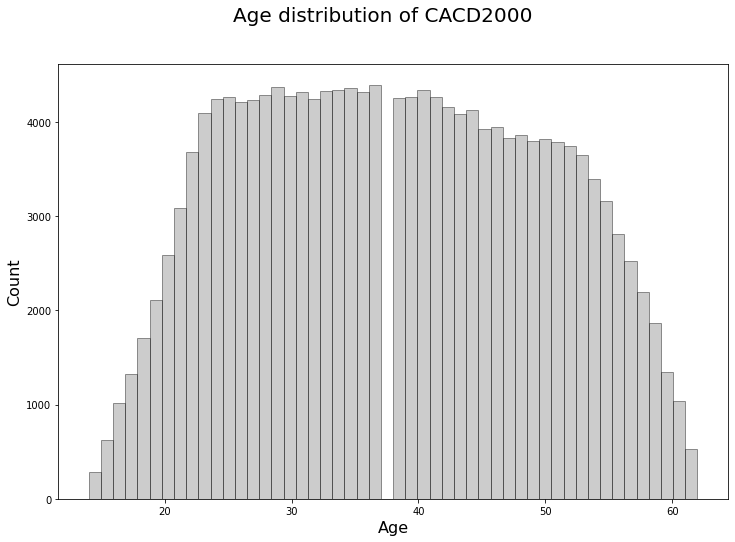

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.hist(metadata_CACD['age'], bins=50, color='gray', alpha=0.4, histtype='bar', ec='black')
plt.xlabel("Age", fontsize=16)
plt.ylabel("Count", fontsize=16)
fig.suptitle("Age distribution of CACD2000", fontsize=20)
plt.show()

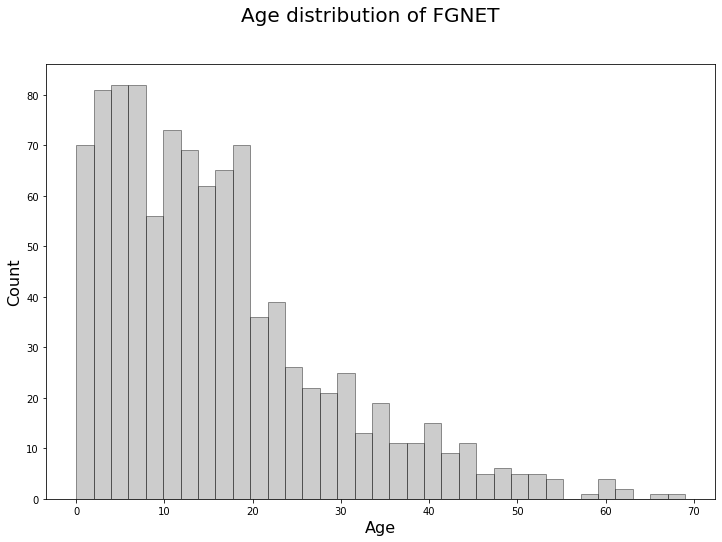

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.hist(metadata_fgnet['age'], bins=35, color='gray', alpha=0.4, histtype='bar', ec='black')
plt.xlabel("Age", fontsize=16)
plt.ylabel("Count", fontsize=16)
fig.suptitle("Age distribution of FGNET", fontsize=20)
plt.show()

### Identity Distribution

In [ ]:
len(np.unique(metadata_agedb['name'])), len(np.unique(metadata_CACD['identity'])), len(np.unique(metadata_fgnet['fileno']))

(567, 2000, 82)

In [ ]:
metadata_agedb.describe().iloc[[0,1,2,3,4,5,6]].style.background_gradient(cmap='coolwarm')

,fileno,age
count,16488.000000,16488.000000
mean,8243.500000,46.261220
std,4759.819955,17.438963
min,0.000000,1.000000
25%,4121.750000,32.000000
50%,8243.500000,44.000000
75%,12365.250000,59.000000


In [ ]:
metadata_agedb.describe()[['age']].iloc[[1,2,3,4,5,6]].to_csv('metadata_agedb.csv')

In [ ]:
metadata_CACD.describe()[['age']].iloc[[1,2,3,4,5,6]].style.background_gradient(cmap='coolwarm')

,age
mean,38.034592
std,11.726101
min,14.000000
25%,28.000000
50%,38.000000
75%,48.000000


In [ ]:
metadata_fgnet.describe(include='all')[['age']].iloc[:].style.background_gradient(cmap='coolwarm')

,age
count,1002.000000
unique,nan
top,nan
freq,nan
mean,15.840319
std,12.867280
min,0.000000
25%,6.000000
50%,13.000000
75%,22.000000


In [ ]:
from sklearn.datasets import make_moons

In [ ]:
dataset = make_moons(n_samples=1000, noise=0.2)

In [ ]:
X, y = dataset

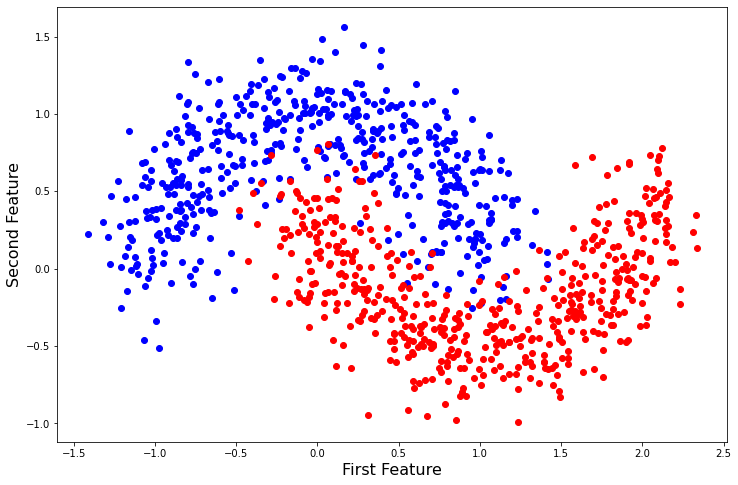

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue')
plt.scatter(X[y==1, 0], X[y==1, 1], color='red')
plt.xlabel("First Feature", fontsize=16)
plt.ylabel("Second Feature", fontsize=16)
plt.show()

0.98


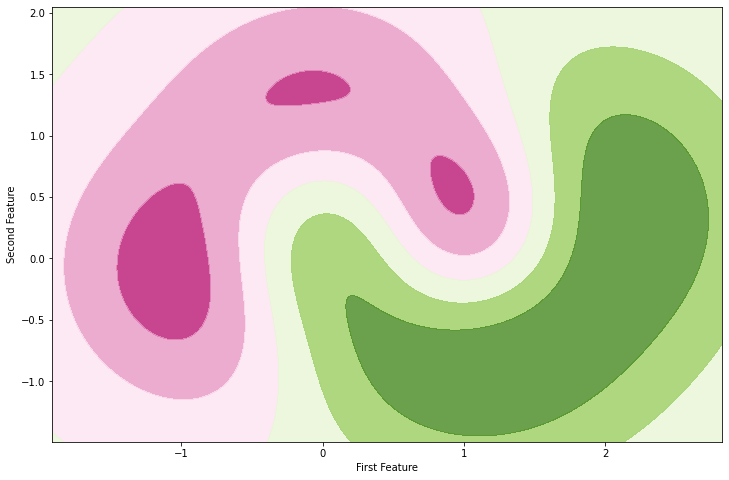

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from matplotlib.colors import ListedColormap

cm_piyg = plt.cm.PiYG
cm_bright = ListedColormap(["#b30065", "#178000"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

h = 0.02  # step size in the mesh

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

param_grid = {"C": np.logspace(-1, 1, 3)}

fig, ax = plt.subplots(1,1,figsize=(12,8))

clf = GridSearchCV(estimator=SVC(), param_grid=param_grid)
with ignore_warnings(category=ConvergenceWarning):
    clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"{score:.2f}")

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
else:
    Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

# put the result into a color plot
Z = Z.reshape(xx.shape)
ax.set_xlabel("First Feature")
ax.set_ylabel("Second Feature")
ax.contourf(xx, yy, Z, cmap=cm_piyg, alpha=0.8)

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
spectral = SpectralClustering(n_clusters=2)
spectral.fit(X)

SpectralClustering(n_clusters=2)

In [ ]:
spectral.labels_

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,

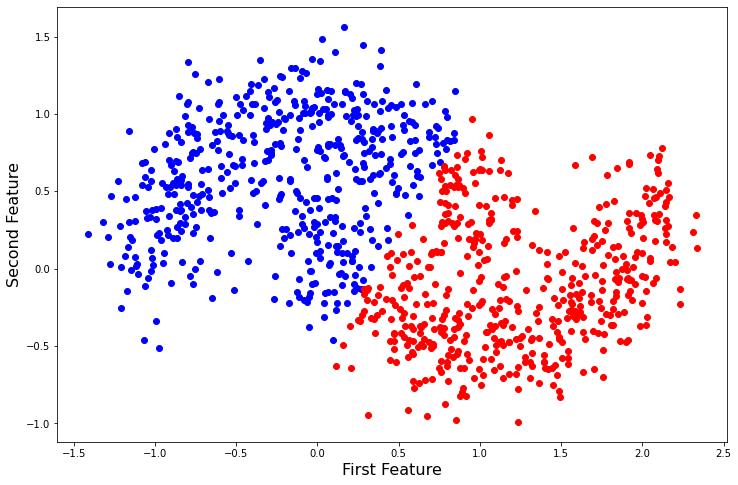

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(X[spectral.labels_==0, 0], X[spectral.labels_==0, 1], color='blue')
plt.scatter(X[spectral.labels_==1, 0], X[spectral.labels_==1, 1], color='red')
plt.xlabel("First Feature", fontsize=16)
plt.ylabel("Second Feature", fontsize=16)
plt.show()

In [ ]:
import numpy as np
import imageio
import cv2
import os

In [ ]:
IMAGESDIR = './facenet_with_aging/hash_sample_1256.0'

In [ ]:
img1 = imageio.imread(os.path.join(IMAGESDIR, 'offset_0_aging_0_age_832_HarrySTruman_67_m.jpg.png'))
img2 = imageio.imread(os.path.join(IMAGESDIR, 'offset_1_aging_0_age_832_HarrySTruman_67_m.jpg.png'))

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [ ]:
orig_image = imageio.imread("../metadata/AgeDB/832_HarrySTruman_67_m.jpg")

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [ ]:
orig_image = cv2.resize(orig_image, (49,49))
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_RGB2GRAY)

In [ ]:
reconstr_img1 = orig_image - 0.1 * img1
reconstr_img2 = orig_image - 0.5 * img1
reconstr_img3 = orig_image - 1.0 * img1

In [ ]:
imageio.imwrite("reconstr_img1.png", reconstr_img1)
imageio.imwrite("reconstr_img2.jpg", reconstr_img2)
imageio.imwrite("reconstr_img3.jpg", reconstr_img3)

Lossy conversion from float64 to uint8. Range [34.1, 216.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [28.0, 115.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-29.0, 59.0]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
imageio.imwrite("orig_image.jpg", orig_image)

In [ ]:
import scipy.stats
from skimage.util import random_noise
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import mean_squared_error
import numpy as np

In [ ]:
psnr_max = 2.0
psnr_pca = []
mse_corr = []
mse_p = []
mse_t = []
for psnr_error in np.arange(1e-4, psnr_max, 1e-1):
  np.random.seed(1000)
  noise_img = random_noise(reconstr_img3/255., mode='s&p',amount=psnr_error)
  noise_img = np.array(255*noise_img, dtype = 'uint8')

  noise_orig_img = random_noise(orig_image/255., mode='s&p',amount=psnr_error)
  noise_orig_img = np.array(255*noise_orig_img, dtype = 'uint8')

  denoised = cv2.fastNlMeansDenoising(noise_img,2,5,7, cv2.NORM_L2)
  denoised_orig = cv2.fastNlMeansDenoising(noise_orig_img,2,5,7, cv2.NORM_L2)

  residual_orig = orig_image - denoised_orig
  residual_img = reconstr_img1 - denoised

  psnr_pca.append(peak_signal_noise_ratio(orig_image/255., output_image/255.))

  covariance = np.cov(denoised/255., residual_img/255.)
  covariance_orig = np.cov(denoised_orig/255., residual_orig/255.)

  corr = covariance[49:, :49] / (np.std(denoised/255.) * np.std(residual_img/255.))
  corr_orig = covariance_orig[49:, :49] / (np.std(denoised_orig/255.) * np.std(residual_orig/255.))

  corr = MinMaxScaler(feature_range=(-0.99,0.99)).fit_transform(corr)
  corr_orig = MinMaxScaler(feature_range=(-0.99,0.99)).fit_transform(corr_orig)

  mse_corr.append(mean_squared_error(corr, corr_orig))

  t_value = corr * np.sqrt((corr.shape[0] - 2) / (1 - corr**2))
  t_value_orig = corr_orig * np.sqrt((corr_orig.shape[0] - 2) / (1 - corr_orig**2))

  mse_t.append(mean_squared_error(t_value, t_value_orig))

  p_value = np.zeros_like(t_value)
  p_value_orig = np.zeros_like(t_value_orig)

  # 2-tailed test because mean diff may be positive or negative
  for ii, _t_value in enumerate(t_value):
      _t_value = [t if t < 0 else -t for t in _t_value]
      cdf1 = scipy.stats.t.cdf(_t_value, df=(t_value.shape[0]*t_value.shape[0]-2))
      p_value[ii] = cdf1

  for ii, _t_value in enumerate(t_value_orig):
      _t_value = [t if t < 0 else -t for t in _t_value]
      cdf1 = scipy.stats.t.cdf(_t_value, df=(t_value_orig.shape[0]+t_value_orig.shape[0]-2))
      p_value_orig[ii] = cdf1

  mse_p.append(mean_squared_error(p_value, p_value_orig))

NameError: ignored

In [ ]:
mean_squared_error(p_value, p_value_orig)

0.1471782647874318

In [ ]:
mean_squared_error(p_value, p_value_orig)

0.14086687972711973

In [ ]:
mean_squared_error(p_value, p_value_orig)

0.14383815971876177

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

print(peak_signal_noise_ratio(orig_image, reconstr_img1))
print(peak_signal_noise_ratio(orig_image, reconstr_img2))
print(peak_signal_noise_ratio(orig_image, reconstr_img3))

24.655280777419417
10.675880690699042
4.655280777419419


C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  after removing the cwd from sys.path.
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  """


In [ ]:
p_value.min(), p_value.max()

(0.0, 0.9996618642246816)

In [ ]:
np.unique(p_value)

array([0.00000000e+000, 8.20115120e-292, 1.32047911e-288, ...,
       9.98725139e-001, 9.99012734e-001, 9.99661864e-001])

In [ ]:
p_value_copy = p_value.copy()
p_value_copy[p_value >= 0.05] = 0.0
p_value_copy[p_value < 0.05] = 1.0

In [ ]:
p_value_orig_copy = p_value_orig.copy()
p_value_orig_copy[p_value_orig >= 0.05] = 0.0
p_value_orig_copy[p_value_orig < 0.05] = 1.0

In [ ]:
p_value_copy.min(), p_value_copy.max()

(0.0, 1.0)

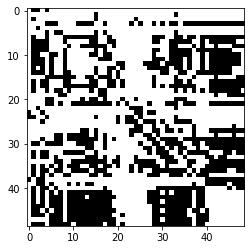

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(p_value_copy, cmap='gray')

In [ ]:
imageio.imwrite("p_value_reconstr_img3.jpg", p_value_copy)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
imageio.imwrite("p_value_orig.jpg", p_value_orig)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Text(0, 0.5, 'Drift Accuracy')

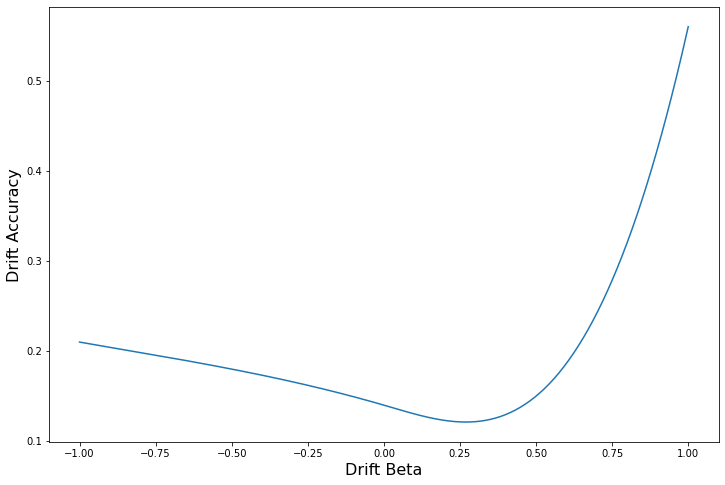

In [ ]:
from scipy.interpolate import make_interp_spline

fig = plt.figure(figsize=(12,8))
x = np.array([-1, -0.5, 0, 0.5, 1])
y = np.array([0.21, 0.18, 0.14, 0.15, 0.56])

X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)
plt.plot(X_, Y_)
plt.xlabel("Drift Beta", fontsize=16)
plt.ylabel("Drift Accuracy", fontsize=16)

Text(0.5, 0.98, 'Variation of MSE between Original Image and Virtual Image')

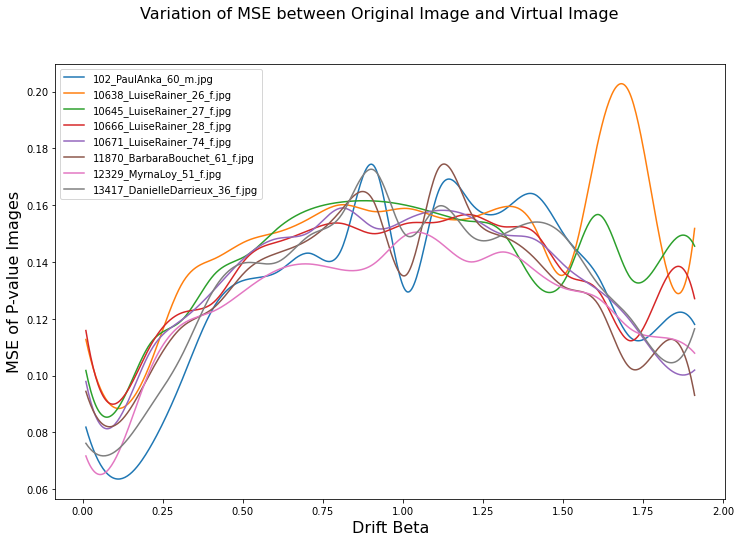

In [ ]:
mse_p_array = pd.read_csv("../../Face_Aging_Concept_Drift/src/data_collection/mse_p_array_df.csv")

fig = plt.figure(figsize=(12,8))
x, y = mse_p_array['drift_beta'], mse_p_array['102_PaulAnka_60_m.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='102_PaulAnka_60_m.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['10638_LuiseRainer_26_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10638_LuiseRainer_26_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['10645_LuiseRainer_27_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10645_LuiseRainer_27_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['10666_LuiseRainer_28_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10666_LuiseRainer_28_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['10671_LuiseRainer_74_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10671_LuiseRainer_74_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['11870_BarbaraBouchet_61_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='11870_BarbaraBouchet_61_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['12329_MyrnaLoy_51_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='12329_MyrnaLoy_51_f.jpg')

x, y = mse_p_array['drift_beta'], mse_p_array['13417_DanielleDarrieux_36_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='13417_DanielleDarrieux_36_f.jpg')
plt.legend()
plt.xlabel("Drift Beta", fontsize=16)
plt.ylabel("MSE of P-value Images", fontsize=16)
fig.suptitle("Variation of MSE between Original Image and Virtual Image", fontsize=16)

Text(0.5, 0.98, 'Variation of PSNR between Original Image and Virtual Image')

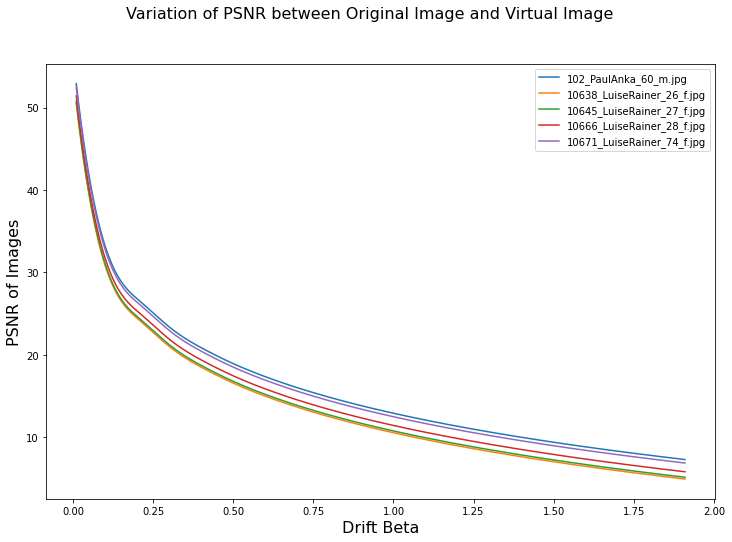

In [ ]:
psnr_pca_df = pd.read_csv("../../Face_Aging_Concept_Drift/src/data_collection/psnr_pca_df.csv")

psnr_pca_df['drift_beta'] = mse_p_array['drift_beta']

fig = plt.figure(figsize=(12,8))
x, y = psnr_pca_df['drift_beta'], psnr_pca_df['102_PaulAnka_60_m.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='102_PaulAnka_60_m.jpg')

x, y = psnr_pca_df['drift_beta'], psnr_pca_df['10638_LuiseRainer_26_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10638_LuiseRainer_26_f.jpg')

x, y = psnr_pca_df['drift_beta'], psnr_pca_df['10645_LuiseRainer_27_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10645_LuiseRainer_27_f.jpg')

x, y = psnr_pca_df['drift_beta'], psnr_pca_df['10666_LuiseRainer_28_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10666_LuiseRainer_28_f.jpg')

x, y = psnr_pca_df['drift_beta'], psnr_pca_df['10671_LuiseRainer_74_f.jpg']
X_Y_spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_spline(X_)

plt.plot(X_, Y_, label='10671_LuiseRainer_74_f.jpg')
plt.legend()
plt.xlabel("Drift Beta", fontsize=16)
plt.ylabel("PSNR of Images", fontsize=16)
fig.suptitle("Variation of PSNR between Original Image and Virtual Image", fontsize=16)

In [ ]:
poly_age = pd.read_csv("../../Face_Aging_Concept_Drift/src/data_collection/drift_synthesis_filename_kernelpca_poly_age.csv", index_col=0)

In [ ]:
poly_age

,hash_sample,offset,true_identity,age,filename,y_pred,y_drift,predicted_age,euclidean,cosine,identity_grouping_distance,orig_TP,orig_FN,virtual_TP,virtual_FN,stat_TP,stat_FP,stat_undefined
0,1,100,PaulAnka,60,102_PaulAnka_60_m.jpg,PaulAnka,EvaMarieSaint,98.60,21.700930,0.019290,2702.280015,1,0,0,1,0,1,0
1,2,100,LuiseRainer,26,10638_LuiseRainer_26_f.jpg,-1,-1,95.53,18.299942,0.081080,278.842637,0,1,0,1,0,0,1
2,3,100,LuiseRainer,27,10645_LuiseRainer_27_f.jpg,-1,-1,112.95,13.172261,0.112385,-619.909680,0,1,0,1,0,0,1
3,4,100,LuiseRainer,28,10666_LuiseRainer_28_f.jpg,-1,-1,106.10,19.973757,0.021514,2132.228247,0,1,0,1,0,0,1
4,5,100,LuiseRainer,74,10671_LuiseRainer_74_f.jpg,-1,-1,99.24,15.842373,0.078597,3101.845291,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,235,100,TomJones,24,9753_TomJones_24_f.jpg,TomJones,AnthonyHopkins,101.01,22.706003,-0.015674,4904.890490,1,0,0,1,0,1,0
235,236,100,TomJones,38,9764_TomJones_38_f.jpg,TomJones,AnthonyHopkins,97.33,22.793362,-0.067809,2106.551868,1,0,0,1,0,1,0
236,237,100,TomJones,68,9782_TomJones_68_f.jpg,TomJones,AnthonyHopkins,99.94,23.306097,0.004475,5729.003909,1,0,0,1,0,1,0
237,238,100,TomJones,69,9783_TomJones_69_f.jpg,TomJones,TomJones,99.98,22.081125,0.146432,0.082276,1,0,1,0,1,0,0


In [ ]:
poly_age['age_group'] = ''

In [ ]:
poly_age.loc[(poly_age['age'] > poly_age['age'].min()) & (poly_age['age'] <= 40), 'age_group'] = 'Group 1'
poly_age.loc[(poly_age['age'] > 40) & (poly_age['age'] <= 70), 'age_group'] = 'Group 2'
poly_age.loc[(poly_age['age'] > 70) & (poly_age['age'] <= poly_age['age'].max()), 'age_group'] = 'Group 3'

In [ ]:
poly_age.groupby('age_group')['orig_TP'].mean(), poly_age.groupby('age_group')['orig_TP'].std()

(age_group
            0.000000
 Group 1    0.750000
 Group 2    0.917431
 Group 3    0.951220
 Name: orig_TP, dtype: float64,
 age_group
                 NaN
 Group 1    0.435494
 Group 2    0.276501
 Group 3    0.218085
 Name: orig_TP, dtype: float64)